# Nuclear segmentation and classification with HoVerNet (CoNSeP)
This tutorial demonstrates how to construct a training workflow of [HoVerNet](https://www.sciencedirect.com/science/article/abs/pii/S1361841519301045) on nuclear segmentation and classification task using the CoNSeP dataset. The architecture of HoVerNet is demonstrated as below.
![image](https://ars.els-cdn.com/content/image/1-s2.0-S1361841519301045-fx1_lrg.jpg)

The following features are included in this tutorial:

1. Transforms for dictionary format data.
2. Load RGB image with metadata, load a list of images and stack them.
3. Randomly flip for data augmentation.
4. Randomly adjust brightness, saturation, contrast and hue for data augmentation.
5. Normalized RGB input between 0 and 1.
6. Cache IO and transforms to accelerate training and validation.
7. HoVerNet model, loss function, Mean Dice metric for nuclear segmentation and classification task.

For more information, access to pre-trained models and distributed training, please refer to HoVerNet official repository:
https://github.com/vqdang/hover_net

The CoNSeP dataset comes from https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/pathology/hovernet/hovernet_training_torch.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q git+https://github.com/Project-MONAI/MONAI#egg=MONAI[torchvision]

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import shutil
import tempfile
import time
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, CacheDataset, Dataset
from monai.apps import download_and_extract
from monai.networks.nets import HoVerNet
from monai.metrics import DiceMetric
from monai.transforms import (
    LoadImaged,
    TorchVisiond,
    Lambda,
    Lambdad,
    Activations,
    OneOf,
    MedianSmoothd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    CastToTyped,
    FillHoles,
    GaussianSmooth,
    ComputeHoVerMapsd,
    ScaleIntensityRanged,
    RandGaussianNoised,
    RandFlipd,
    RandAffined,
    RandGaussianSmoothd,
    CenterSpatialCropd,
)
from monai.apps.pathology.transforms import (
    HoVerNetInstanceMapPostProcessingd,
    HoVerNetNuclearTypePostProcessingd)
from monai.apps.pathology.losses.hovernet_loss import HoVerNetLoss
from monai.apps.pathology.inferers import SlidingWindowHoVerNetInferer

from monai.transforms.utils import apply_transform
from monai.utils import set_determinism, first
from monai.utils.enums import HoVerNetBranch
from monai.visualize import plot_2d_or_3d_image
from skimage import measure
from torch.cuda.amp import GradScaler, autocast


print_config()

MONAI version: 1.1.0rc1+37.gd0f41783
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d0f417830a95eb9e0e03a10e50551f02246543ae
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.0
gdown version: 4.5.3
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.5.0
transformers version: 4.21.3
mlflow version: 1.30.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Set deterministic training for reproducibility

In [4]:
set_determinism(seed=24)

## Download dataset, prepare patch
Each user is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
1. download CoNSeP dataset
2. run ./prepare_patches.py to prepare patches from images. 
  Similar to https://github.com/vqdang/hover_net/blob/master/extract_patches.py

In [5]:
resource = "https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep_dataset.zip"
md5 = "a4fa18067849c536cba5fceee0427e81"

compressed_file = os.path.join(root_dir, "consep_dataset.zip")
data_dir = os.path.join(root_dir, "CoNSeP")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

# Set dataset path

In [6]:
def prepare_data(data_dir, phase):
    # prepare datalist
    images = sorted(
        glob.glob(os.path.join(data_dir, f"{phase}/*image.npy")))
    inst_maps = sorted(
        glob.glob(os.path.join(data_dir, f"{phase}/*inst_map.npy")))
    type_maps = sorted(
        glob.glob(os.path.join(data_dir, f"{phase}/*type_map.npy")))

    data_dicts = [
        {"image": _image, "label_inst": _inst_map, "label_type": _type_map}
        for _image, _inst_map, _type_map in zip(images, inst_maps, type_maps)
    ]

    return data_dicts

## Setup transforms for training and validation
Here we use several transforms to augment the dataset:

1. `LoadImaged` loads the RGB images and labels from npy format files.
2. `measure.label` generate label instance map.
3. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.
4. `CenterSpatialCropd` crop images to input shape.
5. `RandFlipd` random flip images.
6. `OneOf` randomly choose one transform to smooth images.
7. `TorchVisiond` adjust brightness, saturation, contrast and hue based on Torchvision ColorJitter transforms.
8. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
9. `ComputeHoVerMapsd` generate horizontal and vertical distance maps from label instance map.

In [7]:
out_classes = 5
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label_inst", "label_type"], image_only=True),
        Lambdad(keys="label_inst", func=lambda x: measure.label(x)),
        RandAffined(
            keys=["image", "label_inst", "label_type"],
            prob=1.0,
            rotate_range=((np.pi), 0),
            scale_range=((0.2), (0.2)),
            shear_range=((0.05), (0.05)),
            translate_range=((6), (6)),
            padding_mode="zeros",
            mode=("nearest"),
                ),
        CenterSpatialCropd(
            keys="image",
            roi_size=(270, 270),
        ),
        RandFlipd(keys=["image", "label_inst", "label_type"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label_inst", "label_type"], prob=0.5, spatial_axis=1),
        OneOf(transforms=[
            RandGaussianSmoothd(keys=["image"], sigma_x=(0.1, 1.1), sigma_y=(0.1, 1.1), prob=1.0),
            MedianSmoothd(keys=["image"], radius=1),
            RandGaussianNoised(keys=["image"], prob=1.0, std=0.05)
        ]),
        CastToTyped(keys="image", dtype=np.uint8),
        TorchVisiond(
            keys=["image"],
            name="ColorJitter",
            brightness=(229 / 255.0, 281 / 255.0),
            contrast=(0.95, 1.10),
            saturation=(0.8, 1.2),
            hue=(-0.04, 0.04)
        ),
        AsDiscreted(keys=["label_type"], to_onehot=[out_classes]),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        CastToTyped(keys="label_inst", dtype=torch.int),
        ComputeHoVerMapsd(keys="label_inst"),
        Lambdad(keys="label_inst", func=lambda x: x > 0, overwrite="label"),
        CenterSpatialCropd(
            keys=["label", "hover_label_inst", "label_inst", "label_type"],
            roi_size=(80, 80),
        ),
        AsDiscreted(keys=["label"], to_onehot=2),
        CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label_inst", "label_type"], image_only=True),
        Lambdad(keys="label_inst", func=lambda x: measure.label(x)),
        CastToTyped(keys=["image", "label_inst"], dtype=torch.int),
        CenterSpatialCropd(
            keys="image",
            roi_size=(270, 270),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        ComputeHoVerMapsd(keys="label_inst"),
        Lambdad(keys="label_inst", func=lambda x: x > 0, overwrite="label"),
        CenterSpatialCropd(
            keys=["label", "hover_label_inst", "label_inst", "label_type"],
            roi_size=(80, 80),
        ),
        CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
    ]
)
infer_transforms = Compose(
    [
        LoadImaged(keys=["image", "label_inst", "label_type"], image_only=True),
        Lambdad(keys="label_inst", func=lambda x: measure.label(x)),
        CastToTyped(keys=["image", "label_inst"], dtype=torch.int),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
    ]
)

## Define CacheDataset and DataLoader for training and validation
Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.
To achieve best performance, set cache_rate=1.0 to cache all the data, if memory is not enough, set lower value.
Users can also set cache_num instead of cache_rate, will use the minimum value of the 2 settings.
And set num_workers to enable multi-threads during caching.

In [8]:
data_dir = os.path.join(root_dir, 'CoNSeP/Prepared/')

train_data = prepare_data(data_dir, "Train")
valid_data = prepare_data(data_dir, "Test")

train_ds = CacheDataset(data=train_data, transform=train_transforms,
                        cache_rate=1.0, num_workers=4)
valid_ds = CacheDataset(data=valid_data, transform=val_transforms,
                        cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=16, num_workers=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size=16, num_workers=4, pin_memory=True)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████| 686/686 [00:22<00:00, 30.94it/s]


## Check first data shape and visualize

image: 
    shape torch.Size([16, 3, 270, 270])
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
label: 
    shape torch.Size([16, 2, 80, 80])
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
hover_label_inst: 
    shape torch.Size([16, 2, 80, 80])
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
train number of batches: 83
valid number of batches: 43


Text(0.5, 1.0, 'raw image')

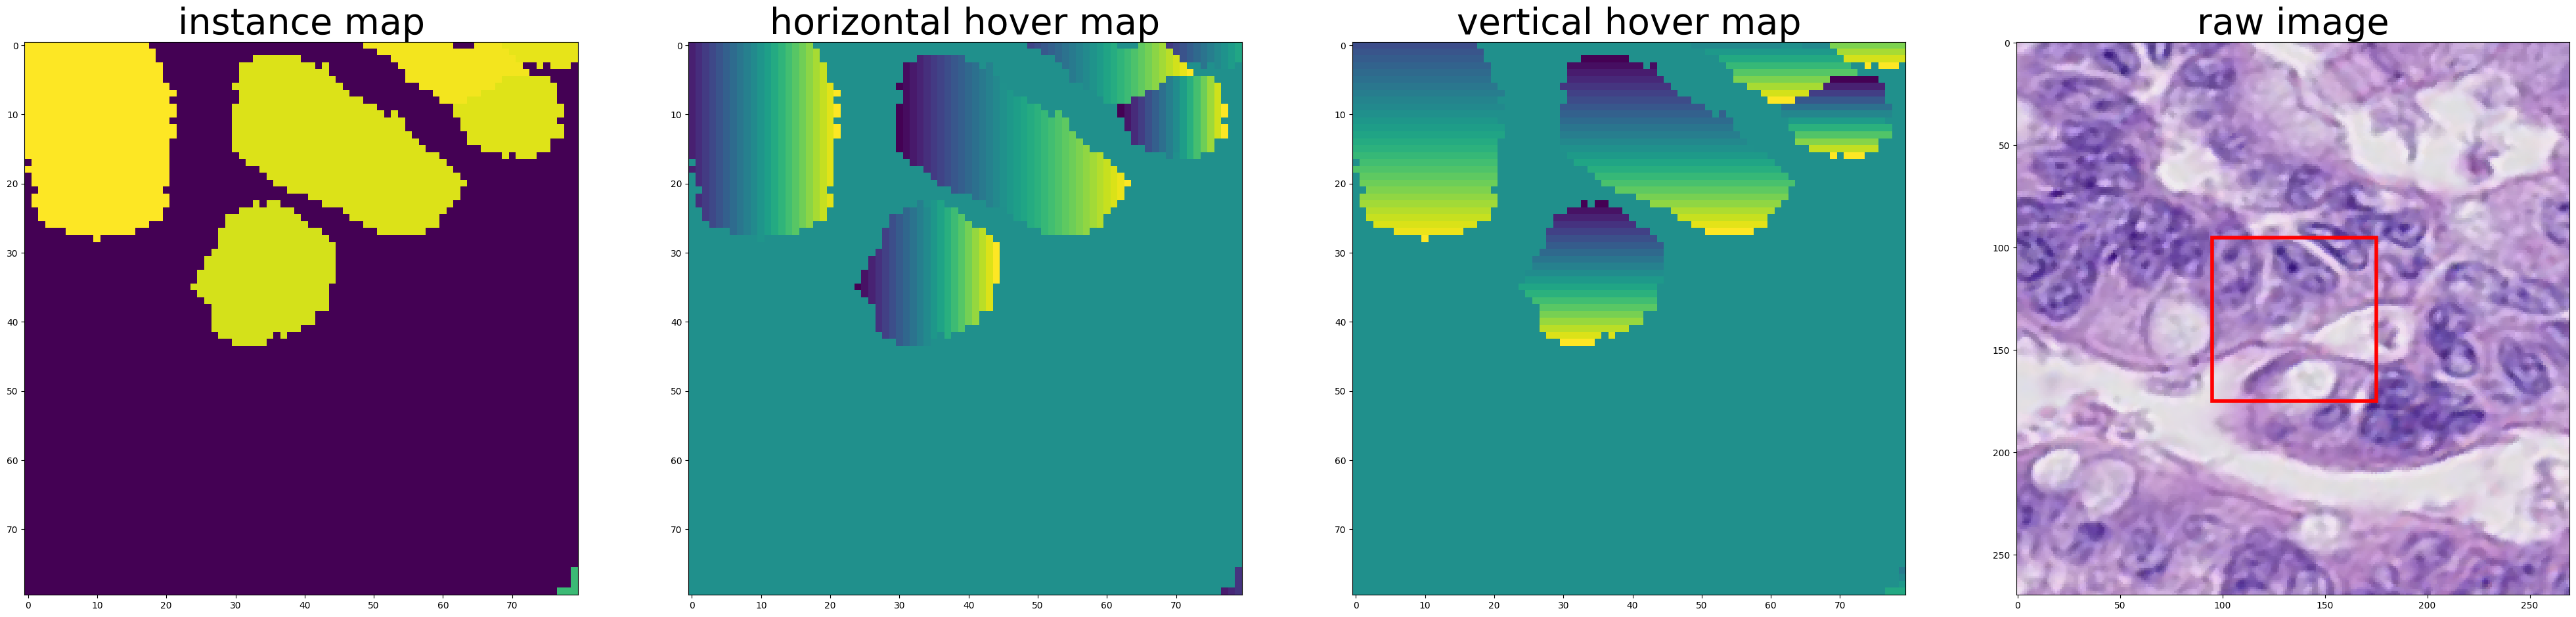

In [13]:
first_sample = first(train_loader)
for k in ("image", "label", "hover_label_inst"):
    print(f"{k}: ")
    print("    shape", first_sample[k].shape)
    print("    type: ", type(first_sample[k]))
    print("    dtype: ", first_sample[k].dtype)
print(f"train number of batches: {len(train_loader)}")
print(f"valid number of batches: {len(val_loader)}")

fig, ax = plt.subplots(1, 4, figsize=(50, 25))
raw_image = (first_sample['image'][0, ...] * 255).astype(np.uint8).transpose(1, 2, 0)

ax[0].imshow(first_sample['label_inst'][0, ...].squeeze())
ax[1].imshow(first_sample['hover_label_inst'][0, 0, ...])
ax[2].imshow(first_sample['hover_label_inst'][0, 1, ...])
ax[3].imshow(raw_image)
ax[3].add_patch(Rectangle((95, 95), 80, 80, fill=False, edgecolor="red", linewidth=4))
ax[0].set_title('instance map', fontsize=40)
ax[1].set_title('horizontal hover map', fontsize=40)
ax[2].set_title('vertical hover map', fontsize=40)
ax[3].set_title('raw image', fontsize=40)

## Create Model, Loss, Optimizer

HoVerNet is training via a two-stage approach. First initialized the model with pre-trained weights on the [ImageNet dataset](https://ieeexplore.ieee.org/document/5206848), trained only the decoders for the first 50 epochs, and then fine-tuned all layers for another 50 epochs. Training used Adam optimizer with an initial learning rate of 10−4 and then reduced it to a rate of 10−5 after 25 epochs. This strategy was repeated for fine-tuning.

Each user is responsible for checking the content of models/datasets and the applicable licenses and determining if suitable for the intended use. The license for the below pre-trained model is different than MONAI license and has been obtained from here: https://github.com/vqdang/hover_net#data-format

In [9]:
# Each user is responsible for checking the content of models/datasets and the applicable licenses and 
# determining if suitable for the intended use.
# The license for the below pre-trained model is different than MONAI license.
# Please check the source where these weights are obtained from for the license.
# https://github.com/vqdang/hover_net/blob/master/LICENSE
pretrained_model = "https://drive.google.com/u/1/uc?id=1KntZge40tAHgyXmHYVqZZ5d2p_4Qr2l5&export=download"

In [10]:
stage = 0
device = torch.device("cuda:0")


def create_model(stage, device):
    if stage == 0:
        model = HoVerNet(
            mode="original",
            in_channels=3,
            out_classes=out_classes,
            act=("relu", {"inplace": True}),
            norm="batch",
            pretrained_url=pretrained_model,
            freeze_encoder=True,
        ).to(device)
        print(f'stage{stage} start!')
    else:
        model = HoVerNet(
            mode="original",
            in_channels=3,
            out_classes=out_classes,
            act=("relu", {"inplace": True}),
            norm="batch",
            pretrained_url=None,
            freeze_encoder=False,
        ).to(device)
        model.load_state_dict(torch.load(os.path.join(writer.log_dir, "model_49.pth")))
        print(f'stage{stage}, success load weight!')

    return model


model = create_model(stage, device)
loss_function = HoVerNetLoss(lambda_hv_mse=1.0)

# original paper
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001,
    weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

# lizard dataset
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.0)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

dice_metric = DiceMetric(include_background=False, reduction="mean")

2022-12-08 03:27:18,212 - INFO - Expected md5 is None, skip md5 check for file /root/.cache/torch/hub/preact-resnet50.pth.
2022-12-08 03:27:18,212 - INFO - File exists: /root/.cache/torch/hub/preact-resnet50.pth, skipped downloading.
stage0 start!


## Execute a typical PyTorch training process

Here we use `DiceMetric` in MONAI to evaluate the performance of segmentation which compute one Dice for each patch and then mean by channel (accounting for nans), then by batch.
From [original paper](https://github.com/vqdang/hover_net/blob/842964dc5d26ffe196d236d16fad16643a103850/models/hovernet/run_desc.py#L263) which sum the intersection and union areas over the batch dimension before the dividing.
Using our pipeline with their metrics. We reproduce the results with Dice: 0.82762; PQ: 0.48976; F1d: 0.73592

In [ ]:
amp = True
scaler = GradScaler()
max_epochs = 100
val_interval = 2

post_process_np = Compose([Activations(softmax=True), AsDiscrete(argmax=True)])
writer = SummaryWriter()

total_start = time.time()
globel_step = 0
epoch_loss_values = []
metric_values = []
for epoch in range(max_epochs):
    if epoch == 50:
        model = create_model(1, device)
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.0001,
            weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        globel_step += 1
        inputs, label, label_type, hover_map = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            batch_data["label_type"].to(device),
            batch_data["hover_label_inst"].to(device),
        )

        labels = {
            HoVerNetBranch.NP: label,
            HoVerNetBranch.HV: hover_map,
            HoVerNetBranch.NC: label_type,
        }
        optimizer.zero_grad()
        if amp:
            with autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), globel_step)
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        torch.cuda.empty_cache()
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_label = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                with torch.cuda.amp.autocast(enabled=amp):
                    val_outputs = model(val_inputs)

                # hover origin post
                val_outputs = [post_process_np(i[HoVerNetBranch.NP.value]) for i in decollate_batch(val_outputs)]
                val_label = decollate_batch(val_label)

                dice_metric(y_pred=val_outputs, y=val_label)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            metric_values.append(metric)
            torch.save(
                model.state_dict(),
                os.path.join(writer.log_dir, f"model_{epoch}.pth"),
            )
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)
            plot_2d_or_3d_image(val_inputs, epoch + 1, writer, index=0, tag="image")
            plot_2d_or_3d_image(val_label, epoch + 1, writer, index=0, tag="label")
            plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

        torch.cuda.empty_cache()

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start
print(
    f"train completed, final epoch dice: {metric:.4f} "
    f"total time: {total_time}")

# Plot the loss and metric

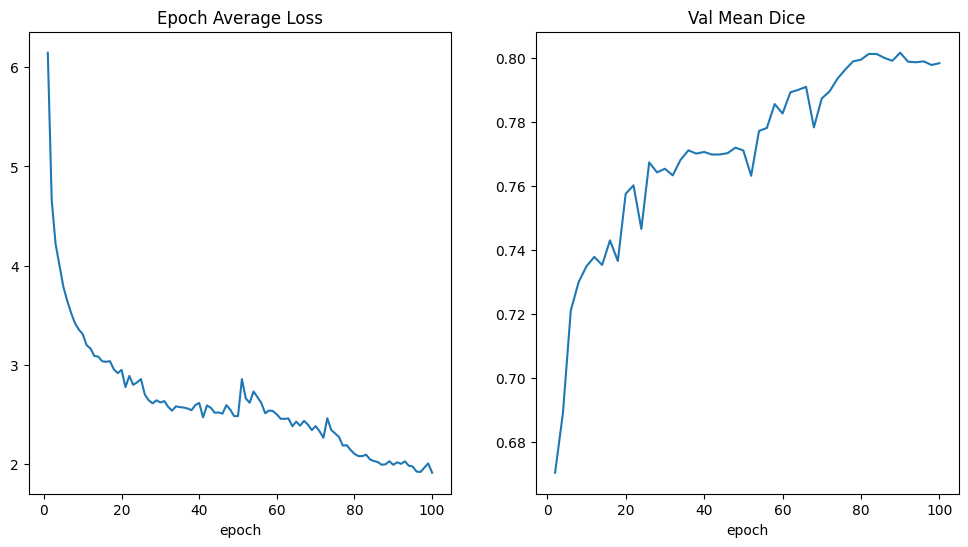

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [12]:
# shuffle the instance id of the instance map for better visualisation
def shuffle_inst_map_id(instance_map):
    instance_id = list(np.unique(instance_map)[1:])  # exclude background
    new_instance_id = np.random.permutation(instance_id)
    new_instance_map = np.zeros(instance_map.shape)
    for i, _instance_id in enumerate(instance_id):
        new_instance_map[instance_map == _instance_id] = new_instance_id[i]
    return new_instance_map

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.57it/s]


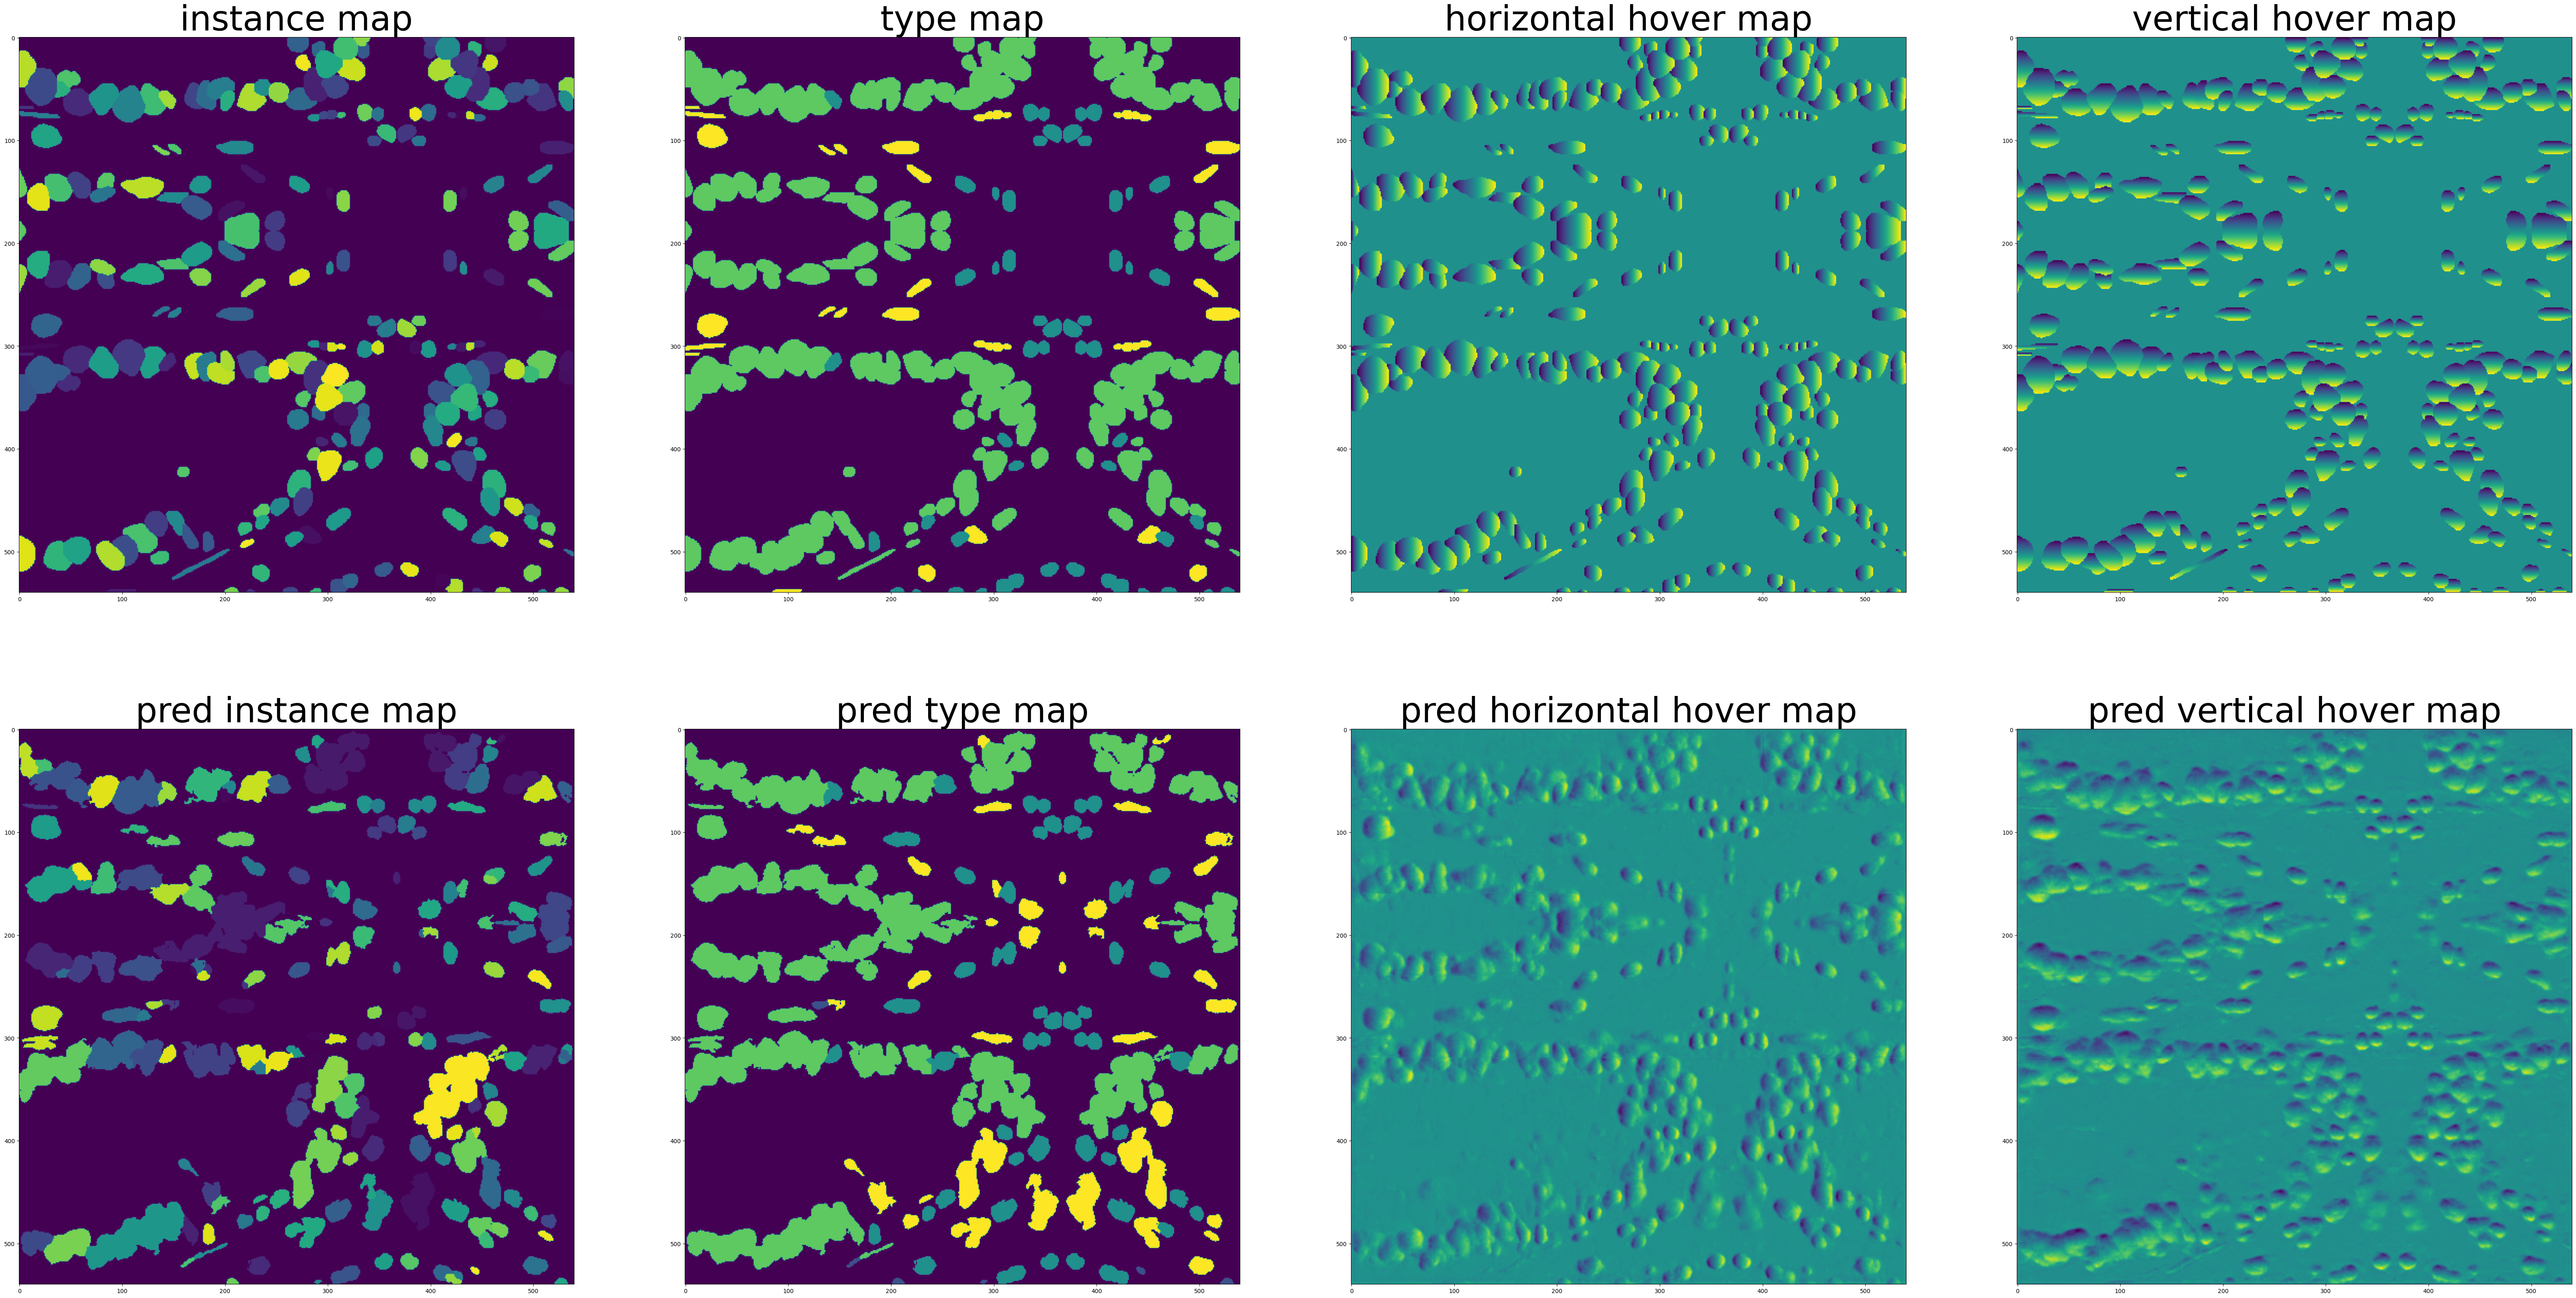

In [17]:
post_transforms = Compose(
    [
        HoVerNetInstanceMapPostProcessingd(sobel_kernel_size=3, marker_threshold=0.6, marker_radius=2),
        HoVerNetNuclearTypePostProcessingd(),
    ]
)

# test postprocess transform 
model.load_state_dict(
    torch.load(os.path.join(writer.log_dir, "model_99.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    valid_ds = Dataset(data=valid_data[:10], transform=infer_transforms)
    val_data = valid_ds[5]
    val_input = val_data["image"].unsqueeze(0).to(device)

    sliding_inferer = SlidingWindowHoVerNetInferer(
        roi_size=270,
        sw_batch_size=8,
        overlap=1.0 - float(80) / float(270),
        padding_mode="constant",
        cval=0,
        sw_device=device,
        device=device,
        progress=True,
        extra_input_padding=((270 - 80) // 2,) * 4,
    )
    val_output = sliding_inferer(val_input, model)
    val_output_ = [apply_transform(post_transforms, i) for i in decollate_batch(val_output)]

    label_inst_map = shuffle_inst_map_id(val_data["label_inst"].squeeze().detach().cpu().numpy())
    pred_inst_map = shuffle_inst_map_id(val_output_[0]["instance_map"].squeeze())

    fig, ax = plt.subplots(2, 4, figsize=(80, 40))
    ax[0, 0].imshow(label_inst_map)
    ax[0, 1].imshow(val_data["label_type"].squeeze().detach().cpu())
    ax[0, 2].imshow(val_data["hover_label_inst"][0, ...].detach().cpu())
    ax[0, 3].imshow(val_data["hover_label_inst"][1, ...].detach().cpu())

    ax[1, 0].imshow(pred_inst_map)
    ax[1, 1].imshow(val_output_[0]["type_map"].squeeze())
    ax[1, 2].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[0, ...])
    ax[1, 3].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[1, ...])

    ax[0, 0].set_title('instance map', fontsize=60)
    ax[0, 1].set_title('type map', fontsize=60)
    ax[0, 2].set_title('horizontal hover map', fontsize=60)
    ax[0, 3].set_title('vertical hover map', fontsize=60)
    ax[1, 0].set_title('pred instance map', fontsize=60)
    ax[1, 1].set_title('pred type map', fontsize=60)
    ax[1, 2].set_title('pred horizontal hover map', fontsize=60)
    ax[1, 3].set_title('pred vertical hover map', fontsize=60)

# Cleanup data directory

Remove directory if a temporary was used.

In [18]:
if directory is None:
    shutil.rmtree(root_dir)